In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA

In [2]:
# Load the datasets
customers_df = pd.read_csv('Customers.csv')
products_df = pd.read_csv('Products.csv')
transactions_df = pd.read_csv('Transactions.csv')

In [3]:
# Convert date columns to datetime format
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])

In [4]:
# Merge datasets
merged_df = transactions_df.merge(customers_df, on='CustomerID', how='inner')
merged_df = merged_df.merge(products_df, on='ProductID', how='inner')
merged_df

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price_x,CustomerName,Region,SignupDate,ProductName,Category,Price_y
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03,ComfortLiving Bluetooth Speaker,Electronics,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11,ComfortLiving Bluetooth Speaker,Electronics,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15,ComfortLiving Bluetooth Speaker,Electronics,300.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,T00630,C0031,P093,2024-10-08 23:58:14,2,609.88,304.94,Tina Miller,South America,2024-04-11,TechPro Vase,Home Decor,304.94
996,T00672,C0165,P044,2024-07-28 00:09:49,4,75.28,18.82,Juan Mcdaniel,South America,2022-04-09,ActiveWear Running Shoes,Clothing,18.82
997,T00711,C0165,P044,2024-06-11 15:51:14,4,75.28,18.82,Juan Mcdaniel,South America,2022-04-09,ActiveWear Running Shoes,Clothing,18.82
998,T00878,C0165,P044,2024-09-24 21:15:21,3,56.46,18.82,Juan Mcdaniel,South America,2022-04-09,ActiveWear Running Shoes,Clothing,18.82


In [5]:
# ===================
# Feature Engineering
# ===================

# Calculate total spending per customer
customer_spending = merged_df.groupby('CustomerID')['TotalValue'].sum().reset_index()
customer_spending.columns = ['CustomerID', 'TotalSpending']

In [6]:
# Calculate transaction count per customer
customer_transactions = merged_df.groupby('CustomerID')['TransactionID'].count().reset_index()
customer_transactions.columns = ['CustomerID', 'TransactionCount']
print(customer_transactions)

    CustomerID  TransactionCount
0        C0001                 5
1        C0002                 4
2        C0003                 4
3        C0004                 8
4        C0005                 3
..         ...               ...
194      C0196                 4
195      C0197                 3
196      C0198                 2
197      C0199                 4
198      C0200                 5

[199 rows x 2 columns]


In [7]:
# Calculate product category preferences per customer
category_preferences = merged_df.pivot_table(index='CustomerID', columns='Category', values='TransactionID', aggfunc='count', fill_value=0).reset_index()
print(category_preferences)

Category CustomerID  Books  Clothing  Electronics  Home Decor
0             C0001      1         0            3           1
1             C0002      0         2            0           2
2             C0003      0         1            1           2
3             C0004      3         0            2           3
4             C0005      0         0            2           1
..              ...    ...       ...          ...         ...
194           C0196      1         1            0           2
195           C0197      0         0            2           1
196           C0198      0         1            1           0
197           C0199      0         0            2           2
198           C0200      1         2            1           1

[199 rows x 5 columns]


In [8]:
# Merge all features into a single dataset
customer_features = customers_df.merge(customer_spending, on='CustomerID', how='left')
customer_features = customer_features.merge(customer_transactions, on='CustomerID', how='left')
customer_features = customer_features.merge(category_preferences, on='CustomerID', how='left')
customer_features

,CustomerID,CustomerName,Region,SignupDate,TotalSpending,TransactionCount,Books,Clothing,Electronics,Home Decor
0,C0001,Lawrence Carroll,South America,2022-07-10,3354.52,5.0,1.0,0.0,3.0,1.0
1,C0002,Elizabeth Lutz,Asia,2022-02-13,1862.74,4.0,0.0,2.0,0.0,2.0
2,C0003,Michael Rivera,South America,2024-03-07,2725.38,4.0,0.0,1.0,1.0,2.0
3,C0004,Kathleen Rodriguez,South America,2022-10-09,5354.88,8.0,3.0,0.0,2.0,3.0
4,C0005,Laura Weber,Asia,2022-08-15,2034.24,3.0,0.0,0.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...
195,C0196,Laura Watts,Europe,2022-06-07,4982.88,4.0,1.0,1.0,0.0,2.0
196,C0197,Christina Harvey,Europe,2023-03-21,1928.65,3.0,0.0,0.0,2.0,1.0
197,C0198,Rebecca Ray,Europe,2022-02-27,931.83,2.0,0.0,1.0,1.0,0.0
198,C0199,Andrea Jenkins,Europe,2022-12-03,1979.28,4.0,0.0,0.0,2.0,2.0


In [9]:
# Fill missing values with 0
customer_features.fillna(0, inplace=True)

In [12]:
# Normalize numerical features for clustering
numerical_features = ['TotalSpending', 'TransactionCount'] + list(category_preferences.columns[1:])
customer_features_normalized = customer_features[numerical_features]
customer_features_normalized = (customer_features_normalized - customer_features_normalized.min()) / (customer_features_normalized.max() - customer_features_normalized.min())

In [19]:
# Clustering
# -------------------
# Use KMeans for clustering
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

cluster_metrics = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    customer_features[f'Cluster_{k}'] = kmeans.fit_predict(customer_features[numerical_features])
    db_index = davies_bouldin_score(customer_features[numerical_features], customer_features[f'Cluster_{k}'])
    cluster_metrics[k] = db_index

In [20]:
# Select optimal number of clusters
optimal_k = min(cluster_metrics, key=cluster_metrics.get)
print(f"Optimal Number of Clusters: {optimal_k}")
print(f"Davies-Bouldin Index for Optimal Clusters: {cluster_metrics[optimal_k]}")

Optimal Number of Clusters: 8
Davies-Bouldin Index for Optimal Clusters: 1.2385086058556265


In [21]:
# Final clustering with optimal_k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(customer_features[numerical_features])

In [22]:
# Visualize clusters using PCA (dimensionality reduction)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
customer_features['PCA1'] = pca.fit_transform(customer_features[numerical_features])[:, 0]
customer_features['PCA2'] = pca.fit_transform(customer_features[numerical_features])[:, 1]

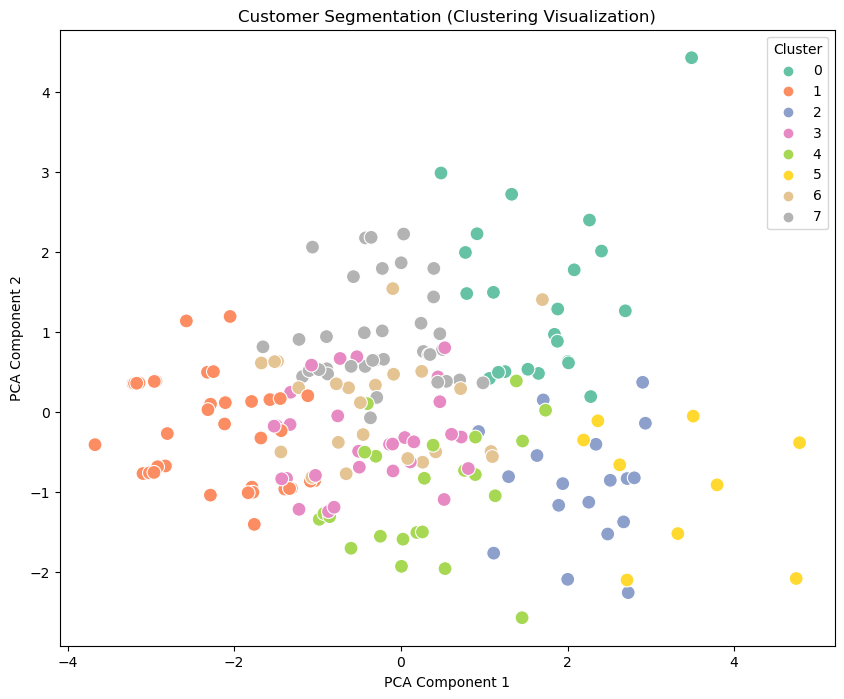

In [23]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=customer_features, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', s=100)
plt.title('Customer Segmentation (Clustering Visualization)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

In [24]:
# Save clustering results
customer_features[['CustomerID', 'Cluster']].to_csv('Customer_Segmentation.csv', index=False)

In [25]:
# Report clustering metrics
print("\nClustering Metrics:")
for k, db_index in cluster_metrics.items():
    print(f"Number of Clusters: {k}, DB Index: {db_index:.4f}")


Clustering Metrics:
Number of Clusters: 2, DB Index: 1.4506
Number of Clusters: 3, DB Index: 1.6213
Number of Clusters: 4, DB Index: 1.5238
Number of Clusters: 5, DB Index: 1.3496
Number of Clusters: 6, DB Index: 1.3838
Number of Clusters: 7, DB Index: 1.2603
Number of Clusters: 8, DB Index: 1.2385
Number of Clusters: 9, DB Index: 1.2575
Number of Clusters: 10, DB Index: 1.2484
